In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_ABOUT_rel'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.4885204081632653
MALE 0.9713541666666666
FEMALE 0.025 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.49747474747474746
MALE 0.9343065693430657
FEMALE 0.026246719160104987 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5110821382007823
MALE 0.9570707070707071
FEMALE 0.03504043126684636 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6822128593921661 	 Validation loss: 0.681791733887236 	 
  1%|          | 574/57400 [02:11<5:28:23,  2.88it/s]
Epoch 2 	 Training loss: 0.676354795798192 	 Validation loss: 0.6750739267316915 	 
  2%|▏         | 1148/57400 [05:24<5:09:14,  3.03it/s]
Epoch 3 	 Training loss: 0.6615699522378968 	 Validation loss: 0.6463323902275603 	 
  3%|▎         | 1722/57400 [08:37<5:03:59,  3.05it/s]
Epoch 4 	 Training loss: 0.5960859315735954 	 Validation loss: 0.5324450115026054 	 
  4%|▍         | 2296/57400 [11:18<4:13:09,  3.63it/s]
Epoch 5 	 Training loss: 0.4888028932365391 	 Validation loss: 0.44557081491260203 	 
  5%|▌         | 2870/57400 [14:04<4:14:26,  3.57it/s]
Epoch 6 	 Training loss: 0.4356074277116862 	 Validation loss: 0.4036677247386868 	 
  6%|▌         | 3444/57400 [17:13<4:53:50,  3.06it/s]
Epoch 7 	 Training loss: 0.40484608133495475 	 Validation loss: 0.3878715780832 	 
  7%|▋         | 4018/57400 [20:23<4:19:49,  3.42it/s]
Epoch 8 	 Training loss:

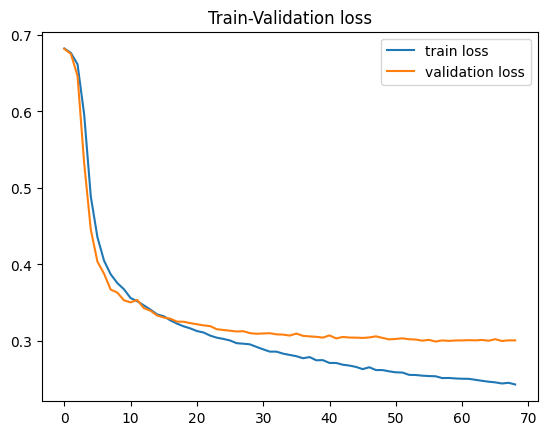

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8392857142857143
MALE 0.8463541666666666
FEMALE 0.8325 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6540404040404041
MALE 0.6788321167883211
FEMALE 0.6272965879265092 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6740547588005215
MALE 0.6616161616161617
FEMALE 0.6873315363881402 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_TO_rel'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6949056026619901 	 Validation loss: 0.6923265184386301 	 
  1%|          | 574/57400 [02:40<4:41:41,  3.36it/s]
Epoch 2 	 Training loss: 0.6945589339483905 	 Validation loss: 0.6927026843620558 	 
  2%|▏         | 1148/57400 [05:24<4:30:42,  3.46it/s]
Epoch 3 	 Training loss: 0.6944180413405654 	 Validation loss: 0.6934738482459116 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [08:38<5:26:04,  2.85it/s]
Epoch 4 	 Training loss: 0.6941784011777685 	 Validation loss: 0.6936562445204136 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [11:53<5:19:21,  2.88it/s]
Epoch 5 	 Training loss: 0.6941402960529726 	 Validation loss: 0.693395463086791 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [14:34<4:08:36,  3.66it/s]
Epoch 6 	 Training loss: 0.6941277048313659 	 Validation loss: 0.6930397152900696 	 
  6%|▌         | 3444/57400 [17:18<4:32:13,  3.30it/s]
Epoch 7 	 Training loss: 0.6939483132304215 	 Validation loss: 0.6935297927

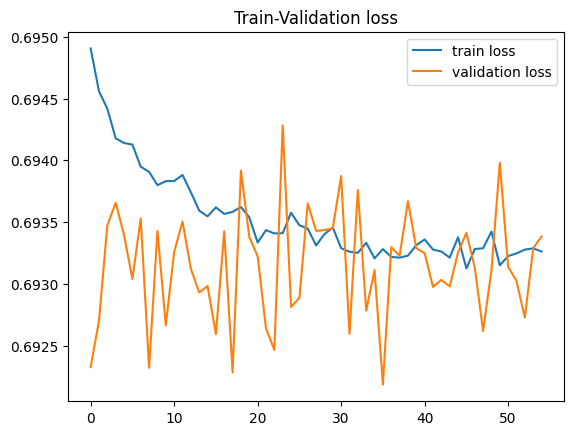

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.47959183673469385
MALE 0.19270833333333334
FEMALE 0.755 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.46085858585858586
MALE 0.20681265206812652
FEMALE 0.7349081364829396 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4758800521512386
MALE 0.20707070707070707
FEMALE 0.7628032345013477 



# AS

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_AS_rel'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944131464908347 	 Validation loss: 0.6925634519528534 	 
  1%|          | 574/57400 [02:15<3:04:44,  5.13it/s]
Epoch 2 	 Training loss: 0.6941247835807268 	 Validation loss: 0.6943510669772908 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:12<3:11:44,  4.89it/s]
Epoch 3 	 Training loss: 0.6940314634751775 	 Validation loss: 0.6931248064768516 	 
  3%|▎         | 1722/57400 [06:11<2:57:10,  5.24it/s]
Epoch 4 	 Training loss: 0.6935354905261395 	 Validation loss: 0.6932250291614209 	 
  4%|▍         | 2296/57400 [08:17<3:20:26,  4.58it/s]
Epoch 5 	 Training loss: 0.6938592018981429 	 Validation loss: 0.6931741682149596 	 
  5%|▌         | 2870/57400 [10:19<3:13:18,  4.70it/s]
Epoch 6 	 Training loss: 0.6936686155272693 	 Validation loss: 0.6929586438809411 	 
  6%|▌         | 3444/57400 [12:25<3:07:19,  4.80it/s]
Epoch 7 	 Training loss: 0.69386574511744 	 Validation loss: 0.6928062954191434 	 
  7%|▋         | 4018/57400 [14:22<2:51:22,  5.19

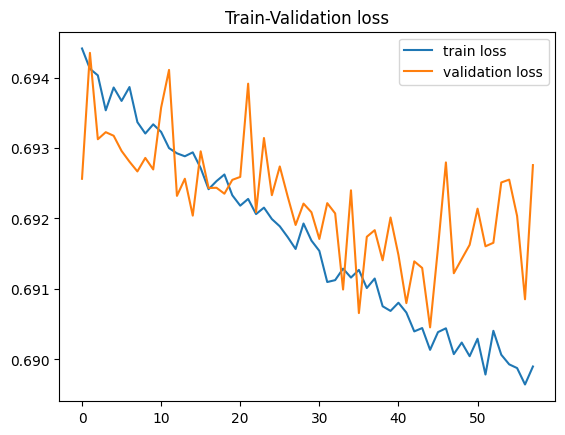

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6122448979591837
MALE 0.5208333333333334
FEMALE 0.7 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5845959595959596
MALE 0.4744525547445255
FEMALE 0.7034120734908137 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6166883963494133
MALE 0.4722222222222222
FEMALE 0.77088948787062 

